<a href="https://colab.research.google.com/github/zinnydigits/hng11internship/blob/main/hngtask1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Ezinne Okechukwu | Data Analyst | adahacos@gmail.com

## HNG DATA ANALYST INTERNSHIP STAGE 1 TASK

In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.spatial import KDTree

In [ ]:
# load data
data = pd.read_csv('ANAMBRA_crosschecked.csv')
data.head(5)

,State,LGA,Ward,PU-Code,PU-Name,Accredited_Voters,Registered_Voters,Results_Found,Transcription_Count,Result_Sheet_Stamped,Result_Sheet_Corrected,Result_Sheet_Invalid,Result_Sheet_Unclear,Result_Sheet_Unsigned,APC,LP,PDP,NNPP,Results_File
0,ANAMBRA,AGUATA,ACHINA I,04-01-01-001,ST. CHARLE'S SCHOOL,171,630,True,-1,False,False,False,False,UNKNOWN,0,0,0,0,https://docs.inecelectionresults.net/elections...
1,ANAMBRA,AGUATA,ACHINA I,04-01-01-005,AMANKWU SQUARE,153,500,True,-1,False,False,False,False,UNKNOWN,3,142,0,1,https://docs.inecelectionresults.net/elections...
2,ANAMBRA,AGUATA,ACHINA I,04-01-01-006,COOPERATIVE HALL,121,386,True,-1,False,False,False,False,UNKNOWN,0,0,0,0,https://docs.inecelectionresults.net/elections...
3,ANAMBRA,AGUATA,ACHINA I,04-01-01-008,OCHIEOBU SQUARE,134,426,True,-1,False,False,False,False,UNKNOWN,0,124,4,1,https://docs.inecelectionresults.net/elections...
4,ANAMBRA,AGUATA,ACHINA I,04-01-01-010,OYE MOTOR PARK II,63,166,True,-1,False,False,False,False,UNKNOWN,4,57,0,0,https://docs.inecelectionresults.net/elections...


### Data Inspection and Preparation

In [ ]:
# view columns
data.columns

Index(['State', 'LGA', 'Ward', 'PU-Code', 'PU-Name', 'Accredited_Voters',
       'Registered_Voters', 'Results_Found', 'Transcription_Count',
       'Result_Sheet_Stamped', 'Result_Sheet_Corrected',
       'Result_Sheet_Invalid', 'Result_Sheet_Unclear', 'Result_Sheet_Unsigned',
       'APC', 'LP', 'PDP', 'NNPP', 'Results_File'],
      dtype='object')

In [ ]:
# concatenate location columns to get address needed for geocoding
data['Address'] = data['PU-Name'] + ", "  + data['LGA'] + ", "+ data['State']
data['Address'].head(3)

0    ST. CHARLE'S SCHOOL, AGUATA, ANAMBRA
1         AMANKWU SQUARE, AGUATA, ANAMBRA
2       COOPERATIVE HALL, AGUATA, ANAMBRA
Name: Address, dtype: object

In [ ]:
# drop columns not needed for this task
data = data.drop(columns= ['State', 'LGA', 'Ward', 'PU-Code', 'PU-Name', 'Accredited_Voters', 'Registered_Voters', 'Results_Found', 'Transcription_Count', 'Result_Sheet_Stamped', 'Result_Sheet_Corrected', 'Result_Sheet_Invalid', 'Result_Sheet_Unclear', 'Result_Sheet_Unsigned', 'Results_File'])
data = data[['Address', 'APC', 'LP', 'PDP', 'NNPP']]
data.head(3)

,Address,APC,LP,PDP,NNPP
0,"ST. CHARLE'S SCHOOL, AGUATA, ANAMBRA",0,0,0,0
1,"AMANKWU SQUARE, AGUATA, ANAMBRA",3,142,0,1
2,"COOPERATIVE HALL, AGUATA, ANAMBRA",0,0,0,0


In [ ]:
# check for null values
data.isnull().sum()

Address    0
APC        0
LP         0
PDP        0
NNPP       0
dtype: int64

In [ ]:
# get a summary of the data
data.describe()

,APC,LP,PDP,NNPP
count,3679.000000,3679.000000,3679.000000,3679.000000
mean,1.260669,103.258766,2.413971,0.556401
std,7.910370,77.716562,11.511426,5.703382
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,45.000000,0.000000,0.000000
50%,0.000000,91.000000,1.000000,0.000000
75%,1.000000,144.500000,2.000000,0.000000
max,350.000000,574.000000,465.000000,251.000000


The longitude and latitude of the polling units are needed to group polling units by proximity. <br />
To get the geolocation, use Geocode by Awesome Table to generate geolocations of the polling unit addresses.

In [ ]:
# export data for geocode generation.
data.to_csv('find_geo_anambra.csv')

Geolocations Generated. Import csv file with geolocations.

In [ ]:
# load data
df = pd.read_csv('anambra.csv')
df.head(5)

,Address,Latitude,Longitude,APC,LP,PDP,NNPP
0,"ST. CHARLE'S SCHOOL, AGUATA, ANAMBRA",6.008584,7.100949,0,0,0,0
1,"AMANKWU SQUARE, AGUATA, ANAMBRA",6.008584,7.100949,3,142,0,1
2,"COOPERATIVE HALL, AGUATA, ANAMBRA",6.008584,7.100949,0,0,0,0
3,"OCHIEOBU SQUARE, AGUATA, ANAMBRA",6.008584,7.100949,0,124,4,1
4,"OYE MOTOR PARK II, AGUATA, ANAMBRA",5.965620,7.119106,4,57,0,0


In [ ]:
# Get the latitude and longitude of the first row
first_lat = df.loc[0, 'Latitude']
first_lon = df.loc[0, 'Longitude']

In [ ]:
# Function to calculate Haversine distance from the first row
def haversine(lat1, lon1, lat2, lon2):
        R = 6371.0  # Earth radius in kilometers

        dlat = math.radians(lat2 - lat1)
        dlon = math.radians(lon2 - lon1)
        a = math.sin(dlat / 2)**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        distance = R * c

        return distance

# Function to calculate distance of each pooling unit from the first row
def distance_from_first_row(row):
    return haversine(first_lat, first_lon, row['Latitude'], row['Longitude'])

In [ ]:
# Apply the function to each row to get the distance from the first row
df['Distance'] = df.apply(distance_from_first_row, axis=1)
df.head(3)

,Address,Latitude,Longitude,APC,LP,PDP,NNPP,Distance
0,"ST. CHARLE'S SCHOOL, AGUATA, ANAMBRA",6.008584,7.100949,0,0,0,0,0.0
1,"AMANKWU SQUARE, AGUATA, ANAMBRA",6.008584,7.100949,3,142,0,1,0.0
2,"COOPERATIVE HALL, AGUATA, ANAMBRA",6.008584,7.100949,0,0,0,0,0.0


In [ ]:
# create bins and labels for the proximity grouping
bins = [float('-inf'), 0, 10, 20, 30, 40, 50, float('inf')]
labels = ['New Ward 1', 'New Ward 2', 'New Ward 3', 'New Ward 4', 'New Ward 5', 'New Ward 6', 'New Ward 7']

In [ ]:
# Categorize the distances
df['New Ward'] = pd.cut(df['Distance'], bins=bins, labels=labels)
df['New Ward'].head(3)

0    New Ward 1
1    New Ward 1
2    New Ward 1
Name: New Ward, dtype: category
Categories (7, object): ['New Ward 1' < 'New Ward 2' < 'New Ward 3' < 'New Ward 4' < 'New Ward 5' < 'New Ward 6' < 'New Ward 7']

In [ ]:
 # Group by proximity and calculate statistics
grouped = df.groupby('New Ward', observed = 'False').agg({'Distance': ['count', 'min', 'mean', 'std', 'max']})
grouped

Distance                                                  
              count        min        mean          std           max
New Ward                                                             
New Ward 1      227   0.000000    0.000000     0.000000      0.000000
New Ward 2      127   0.414637    6.026372     2.989963      9.935653
New Ward 3      747  10.047797   13.881610     2.192367     19.907709
New Ward 4     1283  20.062760   24.569470     3.041414     29.995405
New Ward 5      828  30.005218   36.821073     2.308617     39.852246
New Ward 6      271  40.071222   42.404654     0.952923     47.068230
New Ward 7      196  50.943451  224.006672  1277.494916  12305.469620

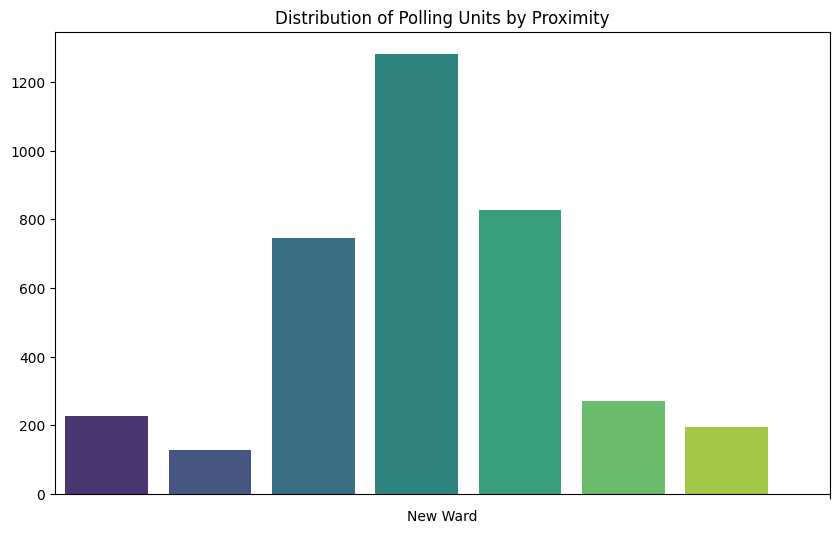

In [ ]:
# Create a count plot
plt.figure(figsize=(10, 6))
sns.countplot(x='New Ward', hue='New Ward', legend = False, data=df, palette='viridis')

# Customize the plot
plt.title('Distribution of Polling Units by Proximity')
plt.xlabel('New Ward')
plt.ylabel('Count')
plt.xticks('')
plt.ylabel('')
plt.show()

In [ ]:
df.head(3)

,Address,Latitude,Longitude,APC,LP,PDP,NNPP,Distance,New Ward
0,"ST. CHARLE'S SCHOOL, AGUATA, ANAMBRA",6.008584,7.100949,0,0,0,0,0.0,New Ward 1
1,"AMANKWU SQUARE, AGUATA, ANAMBRA",6.008584,7.100949,3,142,0,1,0.0,New Ward 1
2,"COOPERATIVE HALL, AGUATA, ANAMBRA",6.008584,7.100949,0,0,0,0,0.0,New Ward 1


In [ ]:
 # Group by ward and calculate mean and IQR for each party's votes
ward_stats = df.groupby('New Ward', observed = False)[['APC', 'LP', 'PDP', 'NNPP']].agg(['mean', 'quantile']).reset_index()

# Function to calculate IQR (Interquartile Range)
def calculate_iqr(x):
   return x.quantile(0.75) - x.quantile(0.25)

In [ ]:
# Group by ward and calculate mean and IQR
ward_stats = df.groupby('New Ward', observed = False).agg({
    'APC': ['mean', calculate_iqr],
    'LP': ['mean', calculate_iqr],
    'PDP': ['mean', calculate_iqr],
    'NNPP': ['mean', calculate_iqr]
    }).reset_index()

In [ ]:
# Rename columns for better readability
ward_stats.columns = ['New Ward', 'APC_mean', 'APC_iqr',
    'LP_mean', 'LP_iqr',
    'PDP_mean', 'PDP_iqr',
    'NNPP_mean', 'NNPP_iqr']
ward_stats.head(3)

,New Ward,APC_mean,APC_iqr,LP_mean,LP_iqr,PDP_mean,PDP_iqr,NNPP_mean,NNPP_iqr
0,New Ward 1,1.246696,1.5,101.290749,86.0,3.242291,2.0,0.629956,1.0
1,New Ward 2,0.779528,1.0,93.527559,72.0,2.267717,2.0,0.464567,0.5
2,New Ward 3,1.239625,1.0,89.270415,71.5,2.424364,2.0,0.605087,0.0


In [ ]:
# Merge the statistics back with the original DataFrame
df_merged = pd.merge(df, ward_stats, on='New Ward')
df_merged.head(3)

,Address,Latitude,Longitude,APC,LP,PDP,NNPP,Distance,New Ward,APC_mean,APC_iqr,LP_mean,LP_iqr,PDP_mean,PDP_iqr,NNPP_mean,NNPP_iqr
0,"ST. CHARLE'S SCHOOL, AGUATA, ANAMBRA",6.008584,7.100949,0,0,0,0,0.0,New Ward 1,1.246696,1.5,101.290749,86.0,3.242291,2.0,0.629956,1.0
1,"AMANKWU SQUARE, AGUATA, ANAMBRA",6.008584,7.100949,3,142,0,1,0.0,New Ward 1,1.246696,1.5,101.290749,86.0,3.242291,2.0,0.629956,1.0
2,"COOPERATIVE HALL, AGUATA, ANAMBRA",6.008584,7.100949,0,0,0,0,0.0,New Ward 1,1.246696,1.5,101.290749,86.0,3.242291,2.0,0.629956,1.0


In [ ]:
# Calculate deviations and outlier scores
for party in ['APC', 'LP', 'PDP', 'NNPP']:
    df_merged[f'{party}_deviation'] = df_merged[f'{party}'] - df_merged[f'{party}_mean']
    df_merged[f'{party}_outlier_score'] = (df_merged[f'{party}_deviation'] / df_merged[f'{party}_iqr']).abs()

In [ ]:
# Sort by outlier scores to identify the most significant outliers
outlier_columns = [f'{party}_outlier_score' for party in ['APC', 'LP', 'PDP', 'NNPP']]
sorted_df = df_merged.sort_values(by=outlier_columns, ascending=False)

sorted_df.head(3)

,Address,Latitude,Longitude,APC,LP,PDP,NNPP,Distance,New Ward,APC_mean,...,NNPP_mean,NNPP_iqr,APC_deviation,APC_outlier_score,LP_deviation,LP_outlier_score,PDP_deviation,PDP_outlier_score,NNPP_deviation,NNPP_outlier_score
1975,"AKABO HALL I, NNEWI SOUTH, ANAMBRA",5.960165,6.985347,350,1,1,1,13.871693,New Ward 3,1.239625,...,0.605087,0.0,348.760375,348.760375,-88.270415,1.234551,-1.424364,0.712182,0.394913,inf
992,"NKWO AMENYI SQUARE II, AWKA SOUTH, ANAMBRA",6.211603,7.071357,228,0,3,2,22.810548,New Ward 4,1.544037,...,0.725643,0.0,226.455963,226.455963,-113.823850,0.994095,0.201871,0.067290,1.274357,inf
1167,"AKWA VILLAGE HALL III, DUNUKOFIA, ANAMBRA",6.200969,6.978633,148,1,8,0,25.308527,New Ward 4,1.544037,...,0.725643,0.0,146.455963,146.455963,-112.823850,0.985361,5.201871,1.733957,-0.725643,inf


In [ ]:
coordinates = df[['Latitude', 'Longitude']].values
tree = KDTree(coordinates)
distances, indices = tree.query(coordinates, k =2)
nearest_neighbour = indices[:, 1]
df_merged['Nearest Pooling Unit'] = df_merged['Address'].iloc[nearest_neighbour].to_list()
df_merged.head(3)

,Address,Latitude,Longitude,APC,LP,PDP,NNPP,Distance,New Ward,APC_mean,...,NNPP_iqr,APC_deviation,APC_outlier_score,LP_deviation,LP_outlier_score,PDP_deviation,PDP_outlier_score,NNPP_deviation,NNPP_outlier_score,Nearest Pooling Unit
0,"ST. CHARLE'S SCHOOL, AGUATA, ANAMBRA",6.008584,7.100949,0,0,0,0,0.0,New Ward 1,1.246696,...,1.0,-1.246696,0.831131,-101.290749,1.177799,-3.242291,1.621145,-0.629956,0.629956,"OZALLA/AKUKWA P.O., AGUATA, ANAMBRA"
1,"AMANKWU SQUARE, AGUATA, ANAMBRA",6.008584,7.100949,3,142,0,1,0.0,New Ward 1,1.246696,...,1.0,1.753304,1.168869,40.709251,0.473363,-3.242291,1.621145,0.370044,0.370044,"OZALLA/AKUKWA P.O., AGUATA, ANAMBRA"
2,"COOPERATIVE HALL, AGUATA, ANAMBRA",6.008584,7.100949,0,0,0,0,0.0,New Ward 1,1.246696,...,1.0,-1.246696,0.831131,-101.290749,1.177799,-3.242291,1.621145,-0.629956,0.629956,"OZALLA/AKUKWA P.O., AGUATA, ANAMBRA"


In [ ]:
df_merged = df_merged.drop(columns = ['APC_mean', 'APC_iqr', 'LP_mean', 'LP_iqr','PDP_mean', 'PDP_iqr', 'NNPP_mean', 'NNPP_iqr', 'APC_deviation',
           'LP_deviation', 'PDP_deviation', 'NNPP_deviation'])
df_merged.head(3)

,Address,Latitude,Longitude,APC,LP,PDP,NNPP,Distance,New Ward,APC_outlier_score,LP_outlier_score,PDP_outlier_score,NNPP_outlier_score,Nearest Pooling Unit
0,"ST. CHARLE'S SCHOOL, AGUATA, ANAMBRA",6.008584,7.100949,0,0,0,0,0.0,New Ward 1,0.831131,1.177799,1.621145,0.629956,"OZALLA/AKUKWA P.O., AGUATA, ANAMBRA"
1,"AMANKWU SQUARE, AGUATA, ANAMBRA",6.008584,7.100949,3,142,0,1,0.0,New Ward 1,1.168869,0.473363,1.621145,0.370044,"OZALLA/AKUKWA P.O., AGUATA, ANAMBRA"
2,"COOPERATIVE HALL, AGUATA, ANAMBRA",6.008584,7.100949,0,0,0,0,0.0,New Ward 1,0.831131,1.177799,1.621145,0.629956,"OZALLA/AKUKWA P.O., AGUATA, ANAMBRA"


In [ ]:
visuals = df_merged.groupby('New Ward', observed = False)[['APC_outlier_score', 'LP_outlier_score', 'PDP_outlier_score', 'NNPP_outlier_score']].max()

In [ ]:
df_merged.to_excel('anambra_outliers.xlsx', index = False)

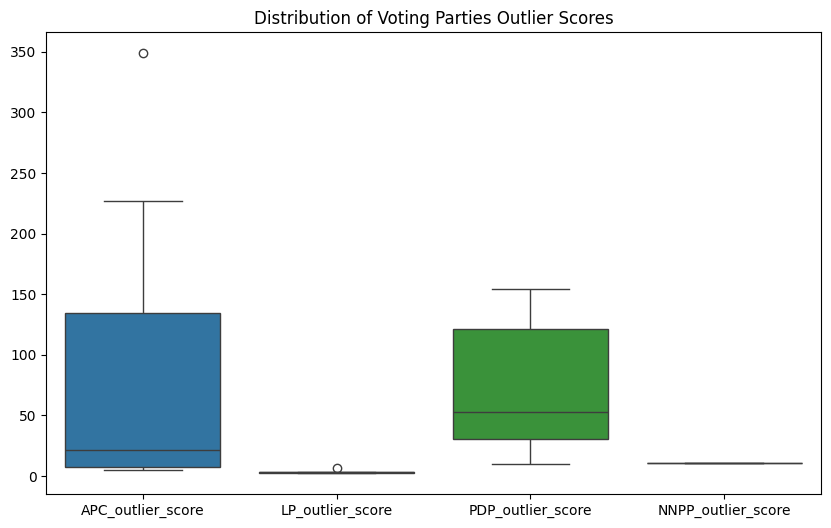

In [ ]:
# visualize distribution of outlier scores
plt.figure(figsize= (10, 6))
sns.boxplot(data = visuals)
plt.title('Distribution of Voting Parties Outlier Scores')
plt.show()